In [27]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import torch
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import Dataset, DataLoader, Subset, RandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

print(torch.__version__)
torch.cuda.is_available()

2.0.0+cu117


True

## Load the table containing participants' information

In [28]:
#input_file1 : patients diagnosis
table = pd.read_csv('/project_space/ADNI_ROY/scripts/adni_table_all.csv')
print(table.head())
print('-'*15, 'the total images are', len(table),'-'*15)
print(table['Path'][0])

  IMAGE_ID     Subject   Acq Date                                 Description  \
0   I75150  941_S_1202  8/24/2007    MPR; GradWarp; B1 Correction; N3; Scaled   
1  I105437  941_S_1202  2/28/2008    MPR; GradWarp; B1 Correction; N3; Scaled   
2   I63874  941_S_1202  1/30/2007  MPR-R; GradWarp; B1 Correction; N3; Scaled   
3  I204843  941_S_1202  3/14/2010    MPR; GradWarp; B1 Correction; N3; Scaled   
4   I63847  941_S_1194  1/20/2007    MPR; GradWarp; B1 Correction; N3; Scaled   

  Visit Group   RID        PTID DX_original         DX    EXAMDATE  Month_bl  \
0   m06    CN  1202  941_S_1202          CN  [1, 0, 0]  2007-08-15   6.03279   
1   m12    CN  1202  941_S_1202          CN  [1, 0, 0]  2008-02-25  12.39340   
2    sc    CN  1202  941_S_1202          CN  [1, 0, 0]  2007-02-12   0.00000   
3   m36    CN  1202  941_S_1202         MCI  [0, 0, 1]  2010-03-10  36.78690   
4    sc    CN  1194  941_S_1194          CN  [1, 0, 0]  2007-02-06   0.00000   

                                

In [29]:
%%capture
#input_file2: patients images

paths = table['Path']

# load and viusalize the images
for path in paths:
    nii_file = nib.load(path)
    data = nii_file.get_fdata().transpose((1, 0, 2))
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, slice_num in enumerate(range(30, 71, 10)):
        axs[i].imshow(data[:, slice_num, :], cmap='gray')
        if i == 0:
            axs[i].set_title(f"sagittal\n{path.split('/')[-1]} Pitch=({slice_num})")
        else:
            axs[i].set_title(f"Pitch=({slice_num})")
    plt.show()

## Load the Dataset

In [30]:
class NeuroImagingDataset(Dataset):
    def __init__(self, data_df, transform = None):
        self.data_df = data_df
        self.transform = transform
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, idx):

        img_path = self.data_df.iloc[idx]['Path']
        #print(img_path)
        label = self.data_df.iloc[idx]['DX_original']
        if label == 'CN':
            label=torch.tensor([1, 0, 0])
        elif label == 'MCI':
            label=torch.tensor([0, 0, 1])
        elif label == 'Dementia':
            label=torch.tensor([0, 1, 0])
            
        img = nib.load(img_path) 
        
        # get the image data as a numpy array
        img = img.get_fdata()
        
        # convert the image to a tensor and add channel dimension
        img =torch.from_numpy(img).unsqueeze(0)
      
        
        if self.transform is not None:
            img = self.transform(img)
            #print('4.self.transform:', img)
         #   print(img.shape)
        #def image_shape(self):
        #    return utils.load_nifti(self.img_path[0]).shape
          
        return img, label


## Split the data into training, validation and test sets (0.8 : 0.1 : 0.1) 

In [31]:
#%%capture
#patient-wise train-test-split
pt_CN = table[table['DX_original'] == 'CN']['PTID'].unique()
pt_MCI = table[table['DX_original'] == 'MCI']['PTID'].unique()
pt_Dementia = table[table['DX_original'] == 'Dementia']['PTID'].unique()

print(f" the total number of patients is {len(table['PTID'].unique())}")
print(f" the total number of patients' diagnoses is {len(pt_CN) + len(pt_MCI) +  len(pt_Dementia)} because one patient has multiple diagnoses")
print(f' - CN: {len(pt_CN)}')
print(f' - MCI: {len(pt_MCI)}')
print(f' - Dementia: {len(pt_Dementia)}')

# Use the train_test_split function twice to get 8(train):1(validation):1(test) ratio ##?? should we do filter
#1
pt_CN_train_val, pt_CN_test = train_test_split(pt_CN, test_size = 0.1, random_state = 0, shuffle = False)
pt_MCI_train_val, pt_MCI_test = train_test_split(pt_MCI, test_size = 0.1, random_state = 0, shuffle = False)
pt_Dementia_train_val, pt_Dementia_test = train_test_split(pt_Dementia, test_size = 0.1, random_state = 0, shuffle = False)

#2
pt_CN_train, pt_CN_val = train_test_split(pt_CN_train_val, test_size = 1/9, random_state = 0, shuffle = False)
pt_MCI_train, pt_MCI_val = train_test_split(pt_MCI_train_val, test_size = 1/9, random_state = 0, shuffle = False)
pt_Dementia_train, pt_Dementia_val = train_test_split(pt_Dementia_train_val, test_size = 1/9,random_state = 0, shuffle = False)

# combine train, validation and test sets
pt_train = np.concatenate([pt_CN_train, pt_MCI_train, pt_Dementia_train])
pt_validation = np.concatenate([pt_CN_val, pt_MCI_val, pt_Dementia_val])
pt_test = np.concatenate([pt_CN_test, pt_MCI_test, pt_Dementia_test])
#print(pt_train)
#print(pt_test)

# Because one patient has multiple images
train_df = table[table['PTID'].isin(pt_train)]
val_df = table[table['PTID'].isin(pt_validation)]
test_df = table[table['PTID'].isin(pt_test)]

#def has_common_element(list1, list2):
#    for element in list1:
#        if element in list2:
#            print(element)

#has_common_element(pt_train, pt_validation)
#print('-'*50)
#has_common_element(pt_train, pt_test)
#print('-'*50)
#has_common_element(pt_validation, pt_test)
#pd.set_option('display.max_colwidth', None)
#print(val_df['Path'])
#print(train_df['Path'])

 the total number of patients is 382
 the total number of patients' diagnoses is 472 because one patient has multiple diagnoses
 - CN: 144
 - MCI: 158
 - Dementia: 170


## Create an instance of the NeuroImagingDataset class

In [21]:
train_dataset = NeuroImagingDataset(data_df = train_df)
validation_dataset = NeuroImagingDataset(data_df = val_df)
test_dataset = NeuroImagingDataset(data_df = test_df)
train_dataset

In [22]:
# Define the data loaders for each set
train_loader = DataLoader(train_dataset, batch_size = 32, drop_last = True) # 42*32 = 1344
val_loader = DataLoader(validation_dataset, batch_size = 32, drop_last = True) # 5*32 =160
test_loader = DataLoader(test_dataset, batch_size  = 32, drop_last = True) # 5*32 = 16
# drop the last batch - drop_last =true
print("Train loader size:", len(train_loader))
print("Val loader size:", len(val_loader))
print("Test loader size:", len(test_loader))
print('total number:', (len(train_loader) + len(val_loader) + len(test_loader))*32)

Train loader size: 42
Val loader size: 5
Test loader size: 5
total number: 1664


## Create a convolutional neural network (CNN) model to train

In [32]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv3d(1,32,3) #kernel_size = 3, stride = 1, padding = 1)
        self.pool1 = nn.MaxPool3d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv3d(32,64,3)#kernel_size = 3, stride = 1, padding = 1)
        self.pool2 = nn.MaxPool3d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(64*22*22*22, 128)
        self.fc2 = nn.Linear(128,3) #final 128 features, 128 nodes
        #output vector sized
        
        
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        print("conv1:", x.shape)
        x = self.pool2(F.relu(self.conv2(x)))
        print("conv2:", x.shape)
        x = x.view(-1, 64*22*22*22)
        print("x.view:", x.shape)
        x = F.relu(self.fc1(x))
        #x = nn.functional.relu(self.fc1(x))
        print("x.nn.functional:", x.shape)
        x = self.fc2(x)
        print("fc2:", x.shape)
        x = F.softmax(x, dim = 1) # what does dimension 1 mean?
        #softmaxit will reutrn normalized every class oupt the probability of every deimesion added upto 1 
        return x

# class MyCNN(nn.Module):
#     def __init__(self):
#         super(MyCNN, self).__init__()
#         self.conv1 = nn.Conv3d(1,32,1) #kernel_size = 3, stride = 1, padding = 1)
#         self.pool1 = nn.MaxPool3d(kernel_size = 2, stride = 2)
#         self.conv2 = nn.Conv3d(32,64,1)#kernel_size = 3, stride = 1, padding = 1)
#         self.pool2 = nn.MaxPool3d(kernel_size = 2, stride = 2)
#         self.conv3 = nn.Conv3d(64,128,1)
#         self.fc1 = nn.Linear(128*24*24*24,128)
#         self.fc2 = nn.Linear(128,3) #final 128 features, 128 nodes
#         #output vector sized
        
#     def forward(self, x):
#         x = self.pool1(F.relu(self.conv1(x)))
#         print("conv1:", x.shape)
#         x = self.pool2(F.relu(self.conv2(x)))
#         print("conv2:", x.shape)
#         #
#         x = F.relu(self.conv3(x))
#         print("conv3:", x.shape)
#         
#         x = x.view(-1, 128*24*24*24)
#         print("x.view:", x.shape)
#         x = nn.functional.relu(self.fc1(x))
#         print("x.nn.functional:", x.shape)
#         x = self.fc2(x)
#         print("fc2:", x.shape)
#         x = F.softmax(x, dim = 1) # what does dimension 1 mean?
#         #softmaxit will reutrn normalized every class oupt the probability of every deimesion added upto 1 
#         return x
    
    


## Define the loss function and optimizer

In [23]:
model = MyCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001) #step size

## Train the model

In [24]:
num_epochs = 1
loss_values = [] #initialize an emptly list to store loss values

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(train_loader,0):
        
        inputs, labels = data
        optimizer.zero_grad()

        inputs_x = inputs.float()
        #inputs_x = torch.mean(inputs_x, dim=1, keepdim=True)
        b, c, d, h, w = inputs_x.shape
        #inputs_x = inputs_x.permute(0,1,2,3,4)
        outputs = model(inputs_x)
        print('y_pred', outputs,outputs.shape)
        #labels = labels.float()
        labels = labels.float()
        #b,c,d,h,w = inputs_x.shape
        print('y_true.shape:',labels.shape)
        print('y_true:',labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch %d loss: %.3f' % (epoch +1, running_loss / len(train_loader)))
    
    loss_values.append(running_loss / len(train_loader)) 
    # append the loss value to the list

conv1: torch.Size([32, 32, 47, 47, 47])
conv2: torch.Size([32, 64, 22, 22, 22])
x.view: torch.Size([32, 681472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
y_pred tensor([[0.7666, 0.1101, 0.1232],
        [0.7567, 0.1338, 0.1094],
        [0.7180, 0.1139, 0.1681],
        [0.6726, 0.1716, 0.1558],
        [0.7423, 0.1675, 0.0903],
        [0.7628, 0.1490, 0.0882],
        [0.7771, 0.1305, 0.0924],
        [0.7506, 0.1544, 0.0950],
        [0.7655, 0.1212, 0.1133],
        [0.8147, 0.0974, 0.0879],
        [0.8064, 0.0939, 0.0998],
        [0.7779, 0.1062, 0.1159],
        [0.7896, 0.0860, 0.1245],
        [0.7720, 0.0920, 0.1359],
        [0.7555, 0.1068, 0.1377],
        [0.7625, 0.1144, 0.1231],
        [0.7582, 0.1884, 0.0534],
        [0.7069, 0.2232, 0.0698],
        [0.7667, 0.1800, 0.0532],
        [0.7018, 0.2325, 0.0658],
        [0.7472, 0.1997, 0.0530],
        [0.7412, 0.1099, 0.1489],
        [0.7523, 0.1072, 0.1406],
        [0.7163, 0.1181, 0.1656],


conv1: torch.Size([32, 32, 47, 47, 47])
conv2: torch.Size([32, 64, 22, 22, 22])
x.view: torch.Size([32, 681472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
y_pred tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], grad_fn=<SoftmaxBackward0>) torch.Size([32, 3])
y_true.shape: torch.Size([32, 3])
y_true: tensor([[1., 0., 0.],

conv1: torch.Size([32, 32, 47, 47, 47])
conv2: torch.Size([32, 64, 22, 22, 22])
x.view: torch.Size([32, 681472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
y_pred tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], grad_fn=<SoftmaxBackward0>) torch.Size([32, 3])
y_true.shape: torch.Size([32, 3])
y_true: tensor([[0., 0., 1.],

conv1: torch.Size([32, 32, 47, 47, 47])
conv2: torch.Size([32, 64, 22, 22, 22])
x.view: torch.Size([32, 681472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
y_pred tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], grad_fn=<SoftmaxBackward0>) torch.Size([32, 3])
y_true.shape: torch.Size([32, 3])
y_true: tensor([[1., 0., 0.],

conv1: torch.Size([32, 32, 47, 47, 47])
conv2: torch.Size([32, 64, 22, 22, 22])
x.view: torch.Size([32, 681472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
y_pred tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], grad_fn=<SoftmaxBackward0>) torch.Size([32, 3])
y_true.shape: torch.Size([32, 3])
y_true: tensor([[0., 0., 1.],

conv1: torch.Size([32, 32, 47, 47, 47])
conv2: torch.Size([32, 64, 22, 22, 22])
x.view: torch.Size([32, 681472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
y_pred tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], grad_fn=<SoftmaxBackward0>) torch.Size([32, 3])
y_true.shape: torch.Size([32, 3])
y_true: tensor([[0., 1., 0.],

conv1: torch.Size([32, 32, 47, 47, 47])
conv2: torch.Size([32, 64, 22, 22, 22])
x.view: torch.Size([32, 681472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
y_pred tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], grad_fn=<SoftmaxBackward0>) torch.Size([32, 3])
y_true.shape: torch.Size([32, 3])
y_true: tensor([[0., 0., 1.],

conv1: torch.Size([32, 32, 47, 47, 47])
conv2: torch.Size([32, 64, 22, 22, 22])
x.view: torch.Size([32, 681472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
y_pred tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], grad_fn=<SoftmaxBackward0>) torch.Size([32, 3])
y_true.shape: torch.Size([32, 3])
y_true: tensor([[1., 0., 0.],

conv1: torch.Size([32, 32, 47, 47, 47])
conv2: torch.Size([32, 64, 22, 22, 22])
x.view: torch.Size([32, 681472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
y_pred tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], grad_fn=<SoftmaxBackward0>) torch.Size([32, 3])
y_true.shape: torch.Size([32, 3])
y_true: tensor([[0., 0., 1.],

In [16]:
ls

mvgi##notes
# conv1: torch.Size([32, 32, 48, 48, 48]) 
#     #[batch size, feature, pixel(x), pixel(y), pixel(z)]
#     # dimension reduction (pixels 96 -> 48)
# conv2: torch.Size([32, 64, 24, 24, 24]) # dimension reduction (pixels 48 -> 24)
# conv3: torch.Size([32, 128, 24, 24, 24]) # when last pool we didn't change
# x.view: torch.Size([32, 1769472]) # 128*24*24*24
# x.nn.functional: torch.Size([32, 128])
# fc2: torch.Size([32, 3])
# outputs tensor([[0., 0., 1.],

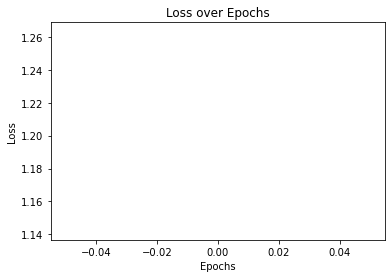

In [18]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the loss values
ax.plot(loss_values)

# Set lables and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Loss over Epochs')

# Display the plot
plt.show()

In [19]:
model.eval() # Set the model to evaluation mode

val_loss = 0.0

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs_x = inputs.float()
        #inputs_x = torch.mean(inputs_x, dim=1, keepdim=True)
        b, c, d, h, w = inputs_x.shape
        inputs_x = inputs_x.permute(0,1,2,3,4)
        outputs = model(inputs_x)
        labels = labels.float()
        b,c,d,h,w = inputs_x.shape
        val_loss += criterion(outputs, labels).item()

print('Validation loss: %.3f' % (val_loss / len(val_loader)))

conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.v

In [31]:
correct = 0
total = 0

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs_x = inputs.float()
        #inputs_x = torch.mean(inputs_x, dim=1, keepdim=True)
        b, c, d, h, w = inputs_x.shape
        inputs_x = inputs_x.permute(0,1,2,3,4)
        outputs = model(inputs_x)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()

#print('Validation accuracy: %.3f %%' % (100 * correct / total))

conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
conv

## Confusion Matrix


## Val. Evaluate the model

In [33]:
#%% capture
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        # covert images and lables to Double tensor
        images = images.float()
        labels = labels.long()
        ouputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.sum().item())

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
      

conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.v

ValueError: only one element tensors can be converted to Python scalars